### Preloads

In [1]:
from IPython.display import clear_output
import time
import logging
import warnings
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! mkdir -p plots/EMG
! mkdir -p plots/GSR
! mkdir -p plots/Resp
! mkdir -p plots/ECG

In [7]:
import os
import sys

import joblib
import gc

from tqdm import tqdm

import numpy as np
from scipy.signal import resample
from scipy.fft import fft, fftfreq
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")

import shutil
from google.colab import files

In [8]:
phases = ['pre_rest', 'stimulus1', 'stimulus2', 'stimulus3', 'post_rest']
stimuli_phases = phases[1:-1]
rest_phases = ['pre_rest', 'post_rest']

In [9]:
import functions as fnc
from functions import TIME_WINDOW, PLOT_TIME_WINDOW, CHILLS_REPORT_WINDOW
from functions import PREPROCESSED_DIR, FEATURES_DIR, DATASET_DIR

In [10]:
PROCESSED_DIR = "drive/MyDrive/chills_dataset/processed"

### Predefs

In [11]:
# @title Analysis Parameters

window = 0.05
select_channel = {"gsr":0, "emg":1, "resp":2, "ecg":3}

In [12]:
# @title Functions

def stack_event_epochs(_signals, sub_phase, phases):
  if sub_phase is not None:
    _array = np.empty((0, int(fs*PLOT_TIME_WINDOW), 4))
  else:
    _array = np.empty((0, int(fs*(TIME_WINDOW+1)), 4))

  for subject in tqdm(_signals, desc="Generating Epochs", total=len(_signals)):
    for phase in phases:

      if (sub_phase is not None) and (phase in stimuli_phases):
        for epoch in _signals[subject][phase]:
            if sub_phase in epoch:

              if epoch[sub_phase].shape[0] != int(fs*PLOT_TIME_WINDOW):
                old_fs = epoch[sub_phase].shape[0] / PLOT_TIME_WINDOW
                n_sample = int(epoch[sub_phase].shape[0] * (fs/old_fs))
                resampled_epoch = resample(epoch[sub_phase], n_sample, axis=0)
                _array = np.vstack((_array, np.expand_dims(resampled_epoch, 0)))
                continue

              _array = np.vstack((_array, np.expand_dims(epoch[sub_phase], 0)))
      else:
        if phase not in phases:
          continue
        for data in _signals[subject][phase]:
          old_fs = data.shape[0] / 300
          if old_fs != fs:
            n_sample = int(data.shape[0] * (fs/old_fs))
            resampled_data = resample(data, n_sample, axis=0)
            data = resampled_data

          T, _ = data.shape
          epoch_length = int((TIME_WINDOW+1)*fs)
          num_epochs = T // epoch_length
          overlap = int(0.1*epoch_length)
          step_size = epoch_length - overlap

          for i in range(num_epochs):
            start_idx = i*step_size
            end_idx = start_idx+epoch_length
            if end_idx>T:
                break
            arr = data[start_idx:end_idx, :]
            _array = np.vstack((_array, np.expand_dims(arr, 0)))

  return _array

def m_avg(arr, perc, pad_mode="symmetric"):
    window_size = int(len(arr) * perc)
    if window_size % 2 == 0:
        window_size += 1  # Ensure window size is odd for better alignment

    kernel = np.ones(window_size) / window_size

    # Pad the array symmetrically to avoid corner effects
    pad_width = window_size // 2
    arr_padded = np.pad(arr, pad_width, mode=pad_mode)

    # Convolve with the padded array
    smoothed = np.convolve(arr_padded, kernel, mode='valid')

    return smoothed

def add_pre_post_subphase(_signals):
  for s, subject in tqdm(enumerate(_signals), desc="Generating Epochs", total=len(_signals)):
    for phase in stimuli_phases:
      if phase not in phases:
        continue
      for e, epoch in enumerate(_signals[subject][phase]):
        if "post" not in epoch:
          continue

        fs_ = epoch["post"].shape[0] / PLOT_TIME_WINDOW
        if fs_!=fs:
          n_sample = int(epoch["post"].shape[0] * (fs/fs_))
          post = resample(epoch["post"], n_sample, axis=0)
        else:
          post = epoch["post"]

        if "pre" in epoch:
          if fs != fs_:
            n_sample = int(epoch["pre"].shape[0] * (fs/fs_))
            pre = resample(epoch["pre"], n_sample, axis=0)
        else:
          pre = np.zeros((int(fs*PLOT_TIME_WINDOW), 4))
          post = post
        _signals[subject][phase][e]["pre_post"] = np.vstack((pre[-1*int(fs):, :], post[:-1*int(fs), :]))

  return _signals

## Analysis 1
- *Compare autonomic markers of augmented chills of Frisson-On Subjects to organic counterparts of same subjects*
- *Compare autonomic responses of augmented chills of Frisson-On Subjects to organic counterparts of same subjects*

In [13]:
# @title Load Signals

frisson_signals = joblib.load(os.path.join(PROCESSED_DIR, "frisson_chills_signal.sav"))
non_chills_signals = joblib.load(os.path.join(PROCESSED_DIR, "non_chills_signal.sav"))
chills_signals = {}


# --> Get only Odd Numbered Subjct Non-Chill Signals
temp ={}
for s, subject in tqdm(enumerate(non_chills_signals)):
  if int(subject)%2 == 0:
    continue
  temp[subject] = non_chills_signals[subject]
non_chills_signals = temp
del temp
gc.collect()

# --> Get only Odd Numbered Authentic Chill Signals
for signal_chunk in tqdm(["chills_signal_chunk_1.sav", "chills_signal_chunk_2.sav", "chills_signal_chunk_3.sav"]):
  _signals = joblib.load(os.path.join(PROCESSED_DIR, signal_chunk))

  for s, subject in enumerate(_signals):
    if int(subject)%2 == 0:
      continue
    chills_signals[subject] = _signals[subject]

  del _signals
  gc.collect()

del signal_chunk
gc.collect()

114it [00:00, 241734.41it/s]
100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


0

### Compare autonomic markers of augmented and organic chills within Frisson-On subjects

In [14]:
fs = 500
baseline_idx = int(fs*(PLOT_TIME_WINDOW-7))
baseline_idx = bidx = (baseline_idx, baseline_idx + fs)

In [17]:
non_chills_epochs = stack_event_epochs(non_chills_signals, None, rest_phases)
frisson_epochs = stack_event_epochs(frisson_signals, "pre", stimuli_phases)
chills_epochs = stack_event_epochs(chills_signals, "pre", stimuli_phases)

print(frisson_epochs.shape, chills_epochs.shape, non_chills_epochs.shape)

(104, 15000, 4) (796, 15000, 4) (3612, 3500, 4) (18, 15000, 4)


#### Time Domain

In [18]:
frisson_ = frisson_epochs.mean(axis=0)
chills_ = chills_epochs.mean(axis=0)
non_chills_ = non_chills_epochs.mean(axis=0)

frisson_baseline = np.expand_dims(frisson_[baseline_idx[0]:baseline_idx[1], :].mean(axis=0), axis=0)
chills_baseline = np.expand_dims(chills_[baseline_idx[0]:baseline_idx[1], :].mean(axis=0), axis=0)
non_chills_baseline = np.expand_dims(non_chills_[:int(fs), :].mean(axis=0), axis=0)

frisson_ = (frisson_ - frisson_baseline)
chills_ = (chills_ - chills_baseline)
non_chills_ = (non_chills_ - non_chills_baseline)

select_channel = {"gsr":0, "emg":1, "resp":2, "ecg":3}
# m_avg = lambda arr, perc: np.convolve(arr, np.ones(int(len(arr) * perc)) / int(len(arr) * perc), mode='same')

window = 0.01
frisson = np.apply_along_axis(lambda x: m_avg(x, window), axis=0, arr=frisson_)
chills = np.apply_along_axis(lambda x: m_avg(x, window), axis=0, arr=chills_)
non_chills = np.apply_along_axis(lambda x: m_avg(x, window), axis=0, arr=non_chills_)

In [ ]:
frisson_std = frisson_epochs[:, bidx[0]:, :].std(axis=0) / len(frisson_epochs)
chills_std = chills_epochs[:, bidx[0]:, :].std(axis=0) / len(chills_epochs)
non_chills_std = non_chills_epochs.std(axis=0) / len(non_chills_epochs)

frisson_std.shape, chills_std.shape, non_chills_std.shape

((3500, 4), (3500, 4), (3500, 4))

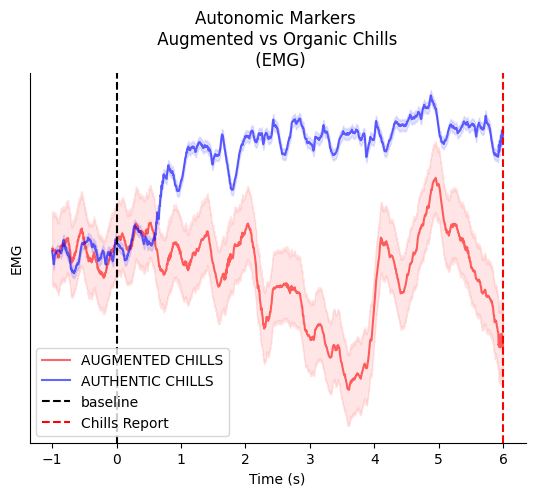

In [ ]:
ch = select_channel["emg"]

y = frisson[bidx[0]:, ch].T
y_std = frisson_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[bidx[0]:, ch].T
y_std = chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUTHENTIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.yticks([])
plt.title("Autonomic Markers \n Augmented vs Organic Chills \n (EMG)")
plt.xlabel("Time (s)")
plt.ylabel("EMG")

plt.legend(loc="lower left")
plt.grid(False)

plt.savefig("plots/emg_organic_vs_augmented_chills_markers.png", dpi=300, bbox_inches="tight")

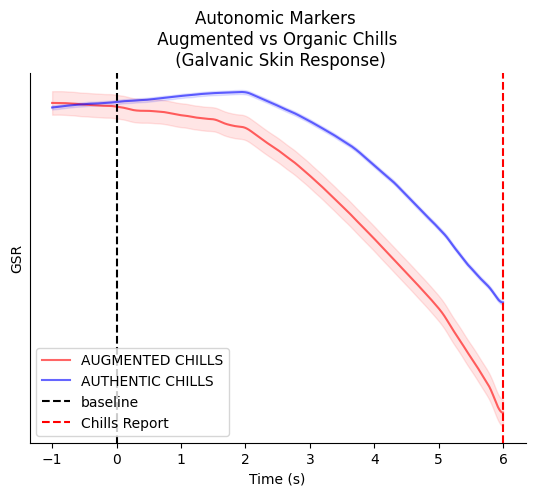

In [ ]:
ch = select_channel["gsr"]

y = frisson[bidx[0]:, ch].T
y_std = frisson_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[bidx[0]:, ch].T
y_std = chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUTHENTIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.yticks([])
plt.title("Autonomic Markers \n Augmented vs Organic Chills \n (Galvanic Skin Response)")
plt.xlabel("Time (s)")
plt.ylabel("GSR")

plt.legend(loc="lower left")
plt.grid(False)

plt.savefig("plots/gsr_organic_vs_augmented_chills_markers.png", dpi=300, bbox_inches="tight")

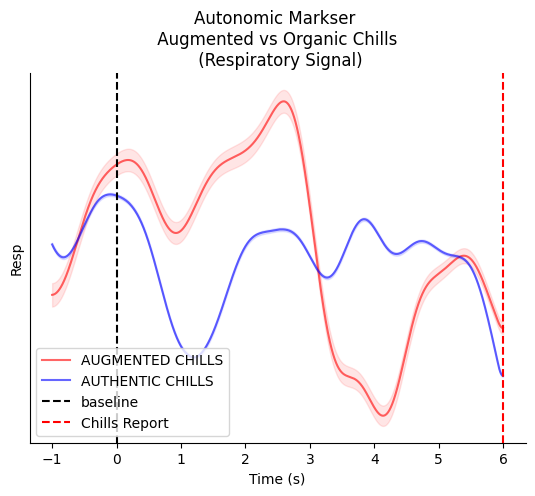

In [ ]:
ch = select_channel["resp"]

y = frisson[bidx[0]:, ch].T
y_std = frisson_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[bidx[0]:, ch].T
y_std = chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUTHENTIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.yticks([])
plt.title("Autonomic Markser \n Augmented vs Organic Chills \n (Respiratory Signal)")
plt.xlabel("Time (s)")
plt.ylabel("Resp")

plt.legend(loc="lower left")
plt.grid(False)

plt.savefig("plots/resp_organic_vs_augmented_chills_markers.png", dpi=300, bbox_inches="tight")

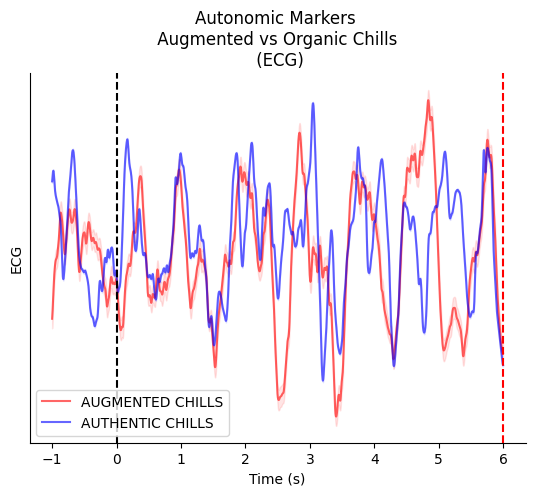

In [ ]:
ch = select_channel["ecg"]

y = frisson[bidx[0]:, ch].T
y_std = frisson_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[bidx[0]:, ch].T
y_std = chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUTHENTIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.legend(loc="lower left")
plt.grid(False)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.yticks([])
plt.title("Autonomic Markers \n Augmented vs Organic Chills \n (ECG)")
plt.xlabel("Time (s)")
plt.ylabel("ECG")

plt.savefig("plots/ecg_organic_vs_augmented_chills_markers.png", dpi=300, bbox_inches="tight")

#### Frequency Domain

In [ ]:
N = int(fs*(TIME_WINDOW))
T = 1/fs

frisson_epochs_fft = np.abs(fft(frisson_epochs[:, bidx[1]:, :], axis=1)[:, N//2:, :])**2
chills_epochs_fft = np.abs(fft(chills_epochs[:, bidx[1]:, :], axis=1)[:, N//2:, :])**2
non_chills_epochs_fft = np.abs(fft(non_chills_epochs[:, fs:, :], axis=1)[:, N//2:, :])**2

frisson_fft = frisson_epochs_fft.mean(axis=0)
chills_fft = chills_epochs_fft.mean(axis=0)
non_chills_fft = non_chills_epochs_fft.mean(axis=0)

freqs = fftfreq(N, T)[:N//2]
freqs_idx = (freqs < 4)
freqs = freqs[freqs_idx]

frisson_fft = frisson_fft[freqs_idx, :]
chills_fft = chills_fft[freqs_idx, :]
non_chills_fft = non_chills_fft[freqs_idx, :]

In [ ]:
frisson_fft_std = frisson_epochs_fft.std(axis=0) / len(frisson_epochs_fft)
chills_fft_std = chills_epochs_fft.std(axis=0) / len(chills_epochs_fft)

frisson_fft_std = frisson_fft_std[freqs_idx, :]
chills_fft_std = chills_fft_std[freqs_idx, :]

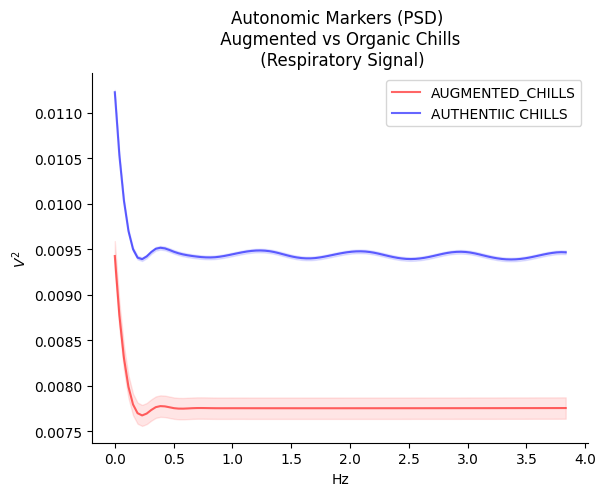

In [ ]:
ch = select_channel["resp"]

new_freqs = np.linspace(freqs.min(), freqs.max(), 100)
frisson_fft_ = CubicSpline(freqs, frisson_fft[:, ch])(new_freqs)
chills_fft_ = CubicSpline(freqs, chills_fft[:, ch])(new_freqs)

y = frisson_fft_
y_std = CubicSpline(freqs, frisson_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(1, 0, 0, 0.6), label="AUGMENTED_CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills_fft_
y_std = CubicSpline(freqs, chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, chills_fft_, color=(0, 0, 1, 0.6), label="AUTHENTIIC CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0, 1, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.legend(loc="upper right")
plt.ylabel(r"$V^2$")
plt.xlabel("Hz")

plt.title("Autonomic Markers (PSD) \n Augmented vs Organic Chills \n (Respiratory Signal)")
plt.savefig("plots/resp_organic_vs_augmented_chills_markers_fft.png", dpi=300, bbox_inches="tight")

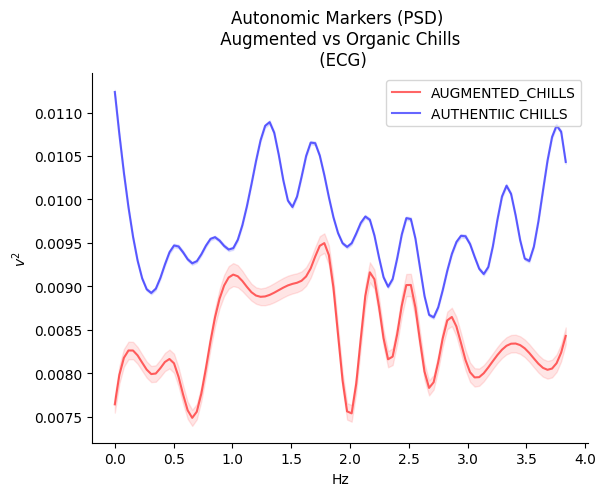

In [ ]:
ch = select_channel["ecg"]

new_freqs = np.linspace(freqs.min(), freqs.max(), 100)
frisson_fft_ = CubicSpline(freqs, frisson_fft[:, ch])(new_freqs)
chills_fft_ = CubicSpline(freqs, chills_fft[:, ch])(new_freqs)

y = frisson_fft_
y_std = CubicSpline(freqs, frisson_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(1, 0, 0, 0.6), label="AUGMENTED_CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills_fft_
y_std = CubicSpline(freqs, chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, chills_fft_, color=(0, 0, 1, 0.6), label="AUTHENTIIC CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0, 1, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.legend(loc="upper right")
plt.ylabel(r"$v^2$")
plt.xlabel("Hz")

plt.title("Autonomic Markers (PSD) \n Augmented vs Organic Chills \n (ECG)")
plt.savefig("plots/ecg_organic_vs_augmented_chills_markers_fft.png", dpi=300, bbox_inches="tight")

### Compare autonomic responses of augmented and organic chills within Frisson-On subjects

In [ ]:
frisson_signals = add_pre_post_subphase(frisson_signals)
chills_signals = add_pre_post_subphase(chills_signals)

Generating Epochs: 100%|██████████| 62/62 [00:01<00:00, 32.45it/s]


In [ ]:
frisson_epochs = stack_event_epochs(frisson_signals, "pre_post", stimuli_phases)
chills_epochs = stack_event_epochs(chills_signals, "pre_post", stimuli_phases)

Generating Epochs: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


In [ ]:
fs = 500
baseline_idx = bidx = (0, fs)

#### Time Domain

In [ ]:
frisson_ = frisson_epochs.mean(axis=0)
chills_ = chills_epochs.mean(axis=0)
# non_chills_ = non_chills_epochs.mean(axis=0)

frisson_baseline = np.expand_dims(frisson_[baseline_idx[0]:baseline_idx[1], :].mean(axis=0), axis=0)
chills_baseline = np.expand_dims(chills_[baseline_idx[0]:baseline_idx[1], :].mean(axis=0), axis=0)
# non_chills_baseline = np.expand_dims(non_chills_[:int(fs), :].mean(axis=0), axis=0)

frisson_ = (frisson_ - frisson_baseline)
chills_ = (chills_ - chills_baseline)
# non_chills_ = (non_chills_ - non_chills_baseline)

window_ = 0.005
frisson = np.apply_along_axis(lambda x: m_avg(x, window_), axis=0, arr=frisson_)
chills = np.apply_along_axis(lambda x: m_avg(x, window_), axis=0, arr=chills_)
# non_chills = np.apply_along_axis(lambda x: m_avg(x, window), axis=0, arr=non_chills_)

In [ ]:
frisson_std = frisson_epochs[:, bidx[0]:, :].std(axis=0) / len(frisson_epochs)
chills_std = chills_epochs[:, bidx[0]:, :].std(axis=0) / len(chills_epochs)
# non_chills_std = non_chills_epochs.std(axis=0) / len(non_chills_epochs)

frisson_std.shape, chills_std.shape,
# frisson_std.shape, chills_std.shape, non_chills_std.shape

((7500, 4), (7500, 4))

(3500,)


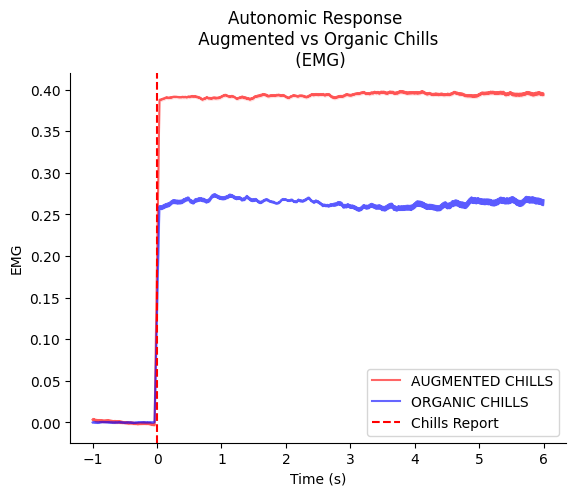

In [ ]:
ch = select_channel["emg"]

sidx = -1*int(fs*(TIME_WINDOW+2))
y = frisson[:sidx, ch].T
y_std = frisson_std[:sidx, ch]
print(y.shape)
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[:sidx, ch].T
y_std = chills_std[:sidx, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="ORGANIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="red", linestyle="--", label="Chills Report")

# plt.yticks([])
plt.title("Autonomic Response \n Augmented vs Organic Chills \n (EMG)")
plt.xlabel("Time (s)")
plt.ylabel("EMG")

plt.legend(loc="lower right")
plt.grid(False)

plt.savefig("plots/emg_organic_vs_augmented_chills_response.png", dpi=300, bbox_inches="tight")

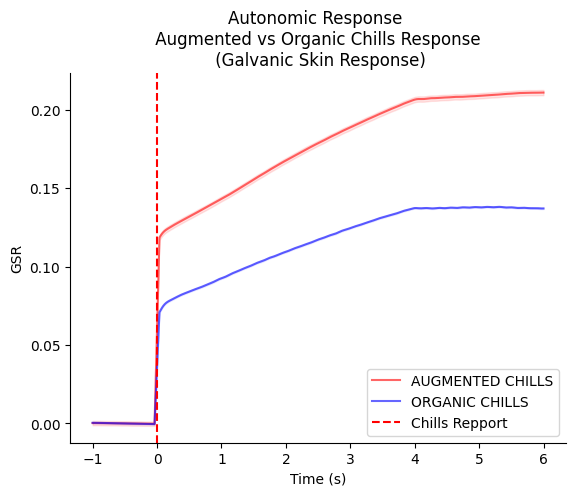

In [ ]:
ch = select_channel["gsr"]

y = frisson[:sidx, ch].T
y_std = frisson_std[:sidx, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[:sidx, ch].T
y_std = chills_std[:sidx, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="ORGANIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(x=0, color="red", linestyle="--", label="Chills Repport")
# plt.yticks([])
plt.title("Autonomic Response \n Augmented vs Organic Chills Response \n (Galvanic Skin Response)")
plt.xlabel("Time (s)")
plt.ylabel("GSR")

plt.legend(loc="lower right")
plt.grid(False)

plt.savefig("plots/gsr_organic_vs_augmented_chills_repsonse.png", dpi=300, bbox_inches="tight")

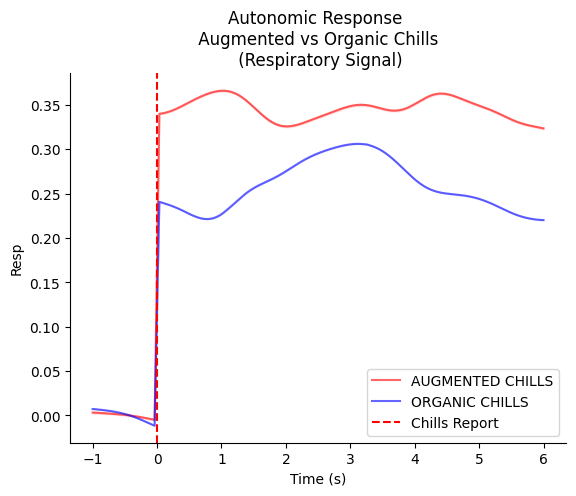

In [ ]:
ch = select_channel["resp"]

y = frisson[:sidx, ch].T
y_std = frisson_std[:sidx, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[:sidx, ch].T
y_std = chills_std[:sidx, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="ORGANIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(x=0, color="red", linestyle="--", label="Chills Report")
# plt.yticks([])
plt.title("Autonomic Response \n Augmented vs Organic Chills \n (Respiratory Signal)")
plt.xlabel("Time (s)")
plt.ylabel("Resp")

plt.legend(loc="lower right")
plt.grid(False)

plt.savefig("plots/resp_organic_vs_augmented_chills_response.png", dpi=300, bbox_inches="tight")

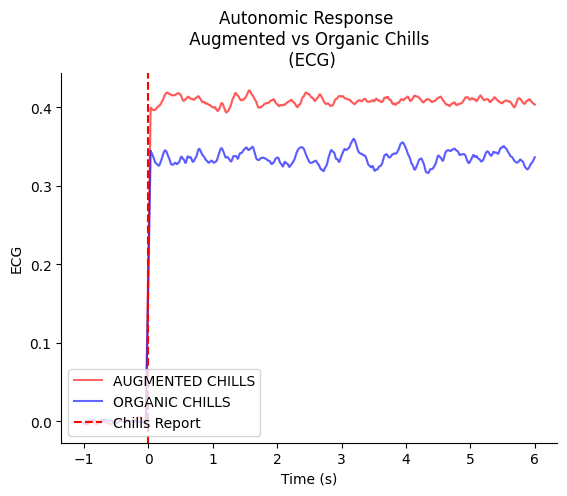

In [ ]:
ch = select_channel["ecg"]

y = frisson[:sidx, ch].T
y_std = frisson_std[:sidx, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="AUGMENTED CHILLS", color=(1, 0, 0, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills[:sidx, ch].T
y_std = chills_std[:sidx, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="ORGANIC CHILLS", color=(0, 0, 1, 0.6))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

# y = non_chills[:, ch].T
# y_std = chills_std[:, ch]
# plt.plot(np.arange(-1, 6, 1/fs), non_chills[:, ch].T, label="NON-CHILLS", color=(0, 1, 0, 0.6))
# plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 1, 0, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(x=0, color="red", linestyle="--", label="Chills Report")
# plt.yticks([])
plt.title("Autonomic Response \n Augmented vs Organic Chills \n (ECG)")
plt.xlabel("Time (s)")
plt.ylabel("ECG")

plt.legend(loc="lower left")
plt.grid(False)

plt.savefig("plots/ecg_organic_vs_augmented_chills_response.png", dpi=300, bbox_inches="tight")

#### Frequency Domain

In [ ]:
N = int(fs*(TIME_WINDOW))
T = 1/fs

frisson_epochs_fft = np.abs(fft(frisson_epochs[:, int(fs):sidx, :], axis=1)[:, N//2:, :])**2
chills_epochs_fft = np.abs(fft(chills_epochs[:, int(fs):sidx, :], axis=1)[:, N//2:, :])**2
# non_chills_epochs_fft = np.abs(fft(non_chills_epochs[:, fs:, :], axis=1)[:, N//2:, :])**2

frisson_fft = frisson_epochs_fft.mean(axis=0)
chills_fft = chills_epochs_fft.mean(axis=0)
# non_chills_fft = non_chills_epochs_fft.mean(axis=0)

freqs = fftfreq(N, T)[:N//2]
freqs_idx = (freqs < 4)
freqs = freqs[freqs_idx]

frisson_fft = frisson_fft[freqs_idx, :]
chills_fft = chills_fft[freqs_idx, :]
# non_chills_fft = non_chills_fft[freqs_idx, :]

In [ ]:
frisson_fft_std = frisson_epochs_fft.std(axis=0) / len(frisson_epochs_fft)
chills_fft_std = chills_epochs_fft.std(axis=0) / len(chills_epochs_fft)

frisson_fft_std = frisson_fft_std[freqs_idx, :]
chills_fft_std = chills_fft_std[freqs_idx, :]

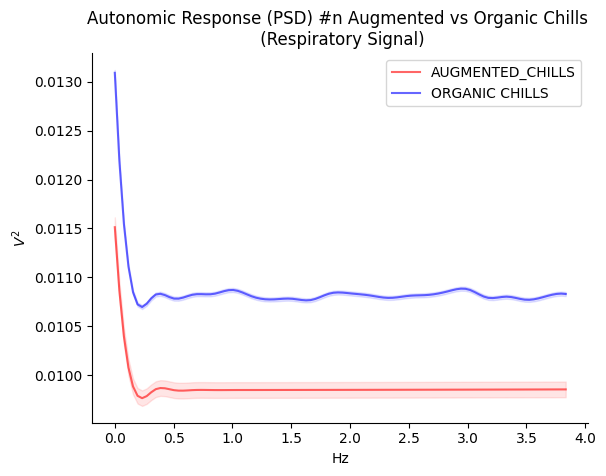

In [ ]:
ch = select_channel["resp"]

new_freqs = np.linspace(freqs.min(), freqs.max(), 100)
frisson_fft_ = CubicSpline(freqs, frisson_fft[:, ch])(new_freqs)
chills_fft_ = CubicSpline(freqs, chills_fft[:, ch])(new_freqs)

y = frisson_fft_
y_std = CubicSpline(freqs, frisson_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(1, 0, 0, 0.6), label="AUGMENTED_CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills_fft_
y_std = CubicSpline(freqs, chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, chills_fft_, color=(0, 0, 1, 0.6), label="ORGANIC CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0, 1, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.legend(loc="upper right")
plt.ylabel(r"$V^2$")
plt.xlabel("Hz")

plt.title("Autonomic Response (PSD) #n Augmented vs Organic Chills \n (Respiratory Signal)")
plt.savefig("plots/resp_organic_vs_augmented_chills_response_fft.png", dpi=300, bbox_inches="tight")

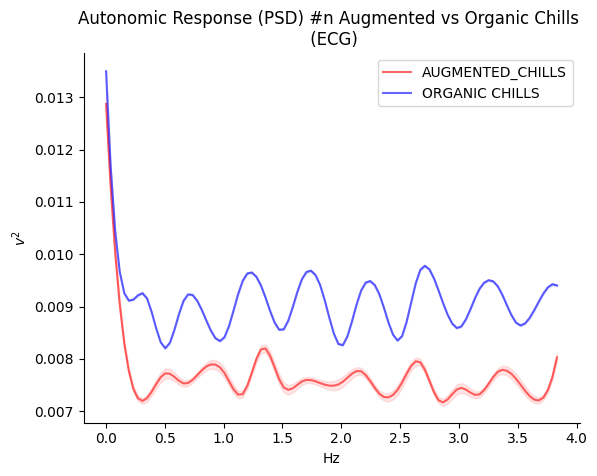

In [ ]:
ch = select_channel["ecg"]

new_freqs = np.linspace(freqs.min(), freqs.max(), 100)
frisson_fft_ = CubicSpline(freqs, frisson_fft[:, ch])(new_freqs)
chills_fft_ = CubicSpline(freqs, chills_fft[:, ch])(new_freqs)

y = frisson_fft_
y_std = CubicSpline(freqs, frisson_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(1, 0, 0, 0.6), label="AUGMENTED_CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(1, 0, 0, 0.1))

y = chills_fft_
y_std = CubicSpline(freqs, chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, chills_fft_, color=(0, 0, 1, 0.6), label="ORGANIC CHILLS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0, 1, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.legend(loc="upper right")
plt.ylabel(r"$v^2$")
plt.xlabel("Hz")

plt.title("Autonomic Response (PSD) #n Augmented vs Organic Chills \n (ECG)")
plt.savefig("plots/ecg_organic_vs_augmented_chills_response_fft.png", dpi=300, bbox_inches="tight")

## Analysis 2
*Compare autonmomic markers of organic chills from Frisson-Off subjects to those of Frisson-On subjects* \

In [ ]:
# @title Load Signals

frisson_signals = joblib.load(os.path.join(PROCESSED_DIR, "frisson_chills_signal.sav"))
non_chills_signals = joblib.load(os.path.join(PROCESSED_DIR, "non_chills_signal.sav"))

even_chills_signals = {}
odd_chills_signals = {}
even_non_chills_signals = {}
odd_non_chills_signals = {}


# --> Get only Odd Numbered Subjct Non-Chill Signals
for s, subject in tqdm(enumerate(non_chills_signals)):
  if int(subject)%2 == 0:
    even_non_chills_signals[subject] = non_chills_signals[subject]
  else:
    odd_non_chills_signals[subject] = non_chills_signals[subject]
del non_chills_signals
gc.collect()

# --> Get only Odd Numbered Authentic Chill Signals
for signal_chunk in tqdm(["chills_signal_chunk_1.sav", "chills_signal_chunk_2.sav", "chills_signal_chunk_3.sav"]):
  _signals = joblib.load(os.path.join(PROCESSED_DIR, signal_chunk))
  for s, subject in enumerate(_signals):
    if int(subject)%2 == 0:
      even_chills_signals[subject] = _signals[subject]
    else:
      odd_chills_signals[subject] = _signals[subject]
  del _signals
  gc.collect()
del signal_chunk
gc.collect()

114it [00:00, 63490.99it/s]
100%|██████████| 3/3 [00:16<00:00,  5.42s/it]


0

In [ ]:
fs = 500
baseline_idx = int(fs*(PLOT_TIME_WINDOW-7))
baseline_idx = bidx = (baseline_idx, baseline_idx + fs)

In [ ]:
even_non_chills_epochs = stack_event_epochs(even_non_chills_signals, None, rest_phases)
odd_non_chills_epochs = stack_event_epochs(odd_non_chills_signals, None, rest_phases)

frisson_epochs = stack_event_epochs(frisson_signals, "pre", stimuli_phases)

even_chills_epochs = stack_event_epochs(even_chills_signals, "pre", stimuli_phases)
odd_chills_epochs = stack_event_epochs(odd_chills_signals, "pre", stimuli_phases)

print(" ")
print(frisson_epochs.shape, (even_chills_epochs.shape, odd_chills_epochs.shape), (even_non_chills_epochs.shape, odd_non_chills_epochs.shape))

Generating Epochs: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]

 
(122, 7500, 4) ((915, 7500, 4), (814, 7500, 4)) ((1848, 3500, 4), (3612, 3500, 4))


### Compare Autonomic Markers of Organic Chills From Frisson On & Off Subjects

#### Time Domain

In [ ]:
even_chills_ = even_chills_epochs.mean(axis=0)
odd_chills_ = odd_chills_epochs.mean(axis=0)

even_chills_baseline = np.expand_dims(even_chills_[bidx[0]:bidx[1], :].mean(axis=0), axis=0)
odd_chills_baseline = np.expand_dims(odd_chills_[bidx[0]:bidx[1], :].mean(axis=0), axis=0)

even_chills_ = (even_chills_ -even_chills_baseline)
odd_chills_ = (odd_chills_ - odd_chills_baseline)

window_ = 0.1
even_chills = np.apply_along_axis(lambda x: m_avg(x, window_), axis=0, arr=even_chills_)
odd_chills = np.apply_along_axis(lambda x: m_avg(x, window_), axis=0, arr=odd_chills_)

In [ ]:
even_chills_std = even_chills_epochs[:, bidx[0]:, :].std(axis=0) / len(even_chills_epochs)
odd_chills_std = odd_chills_epochs[:, bidx[0]:, :].std(axis=0) / len(odd_chills_epochs)

even_chills_std.shape, odd_chills_std.shape

((3500, 4), (3500, 4))

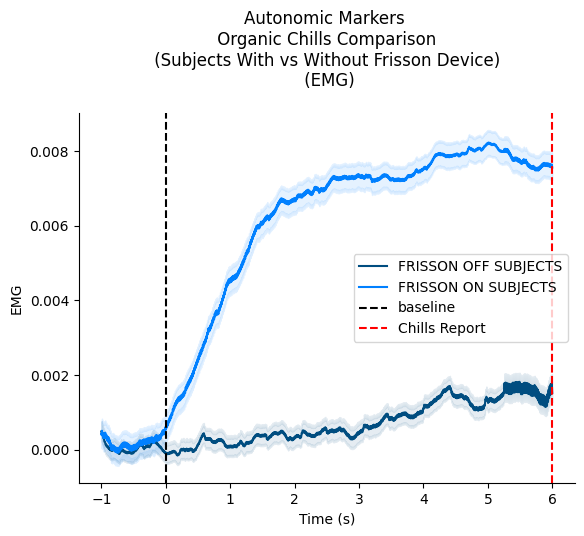

In [ ]:
ch = select_channel["emg"]

y = even_chills[bidx[0]:, ch].T
y_std = even_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON OFF SUBJECTS", color=(0, 0.3, 0.5, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.3, 0.5, 0.1))

y = odd_chills[bidx[0]:, ch].T
y_std = odd_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON ON SUBJECTS", color=(0, 0.5, 1, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.5, 1, 0.1))

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.gca().spines["top"].set_visible(False)

plt.legend(loc="center right")
plt.grid(False)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.ylabel("EMG")
plt.xlabel("Time (s)")

plt.title("Autonomic Markers \n Organic Chills Comparison \n (Subjects With vs Without Frisson Device) \n (EMG)", y=1.05)
plt.savefig("plots/emg_organic_chills_comparison.png", dpi=300, bbox_inches="tight")

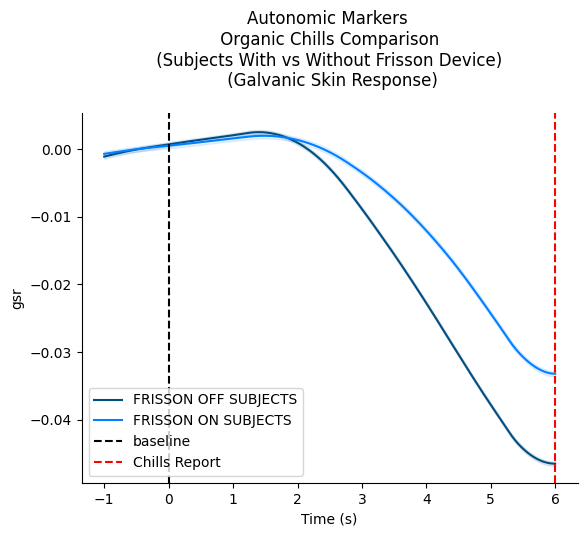

In [ ]:
ch = select_channel["gsr"]

y = even_chills[bidx[0]:, ch].T
y_std = even_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON OFF SUBJECTS", color=(0, 0.3, 0.5, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.3, 0.5, 0.1))

y = odd_chills[bidx[0]:, ch].T
y_std = odd_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON ON SUBJECTS", color=(0, 0.5, 1, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.5, 1, 0.1))

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.gca().spines["top"].set_visible(False)


plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.ylabel("gsr")
plt.xlabel("Time (s)")

plt.legend(loc="lower left")
plt.grid(False)

plt.title("Autonomic Markers \n Organic Chills Comparison \n (Subjects With vs Without Frisson Device) \n (Galvanic Skin Response)", y=1.05)
plt.savefig("plots/gsr_organic_chills_comparison.png", dpi=300, bbox_inches="tight")

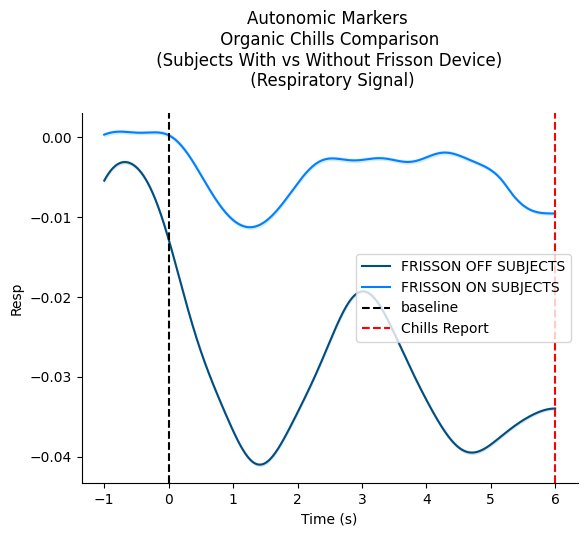

In [ ]:
ch = select_channel["resp"]

y = even_chills[bidx[0]:, ch].T
y_std = even_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON OFF SUBJECTS", color=(0, 0.3, 0.5, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.3, 0.5, 0.1))

y = odd_chills[bidx[0]:, ch].T
y_std = odd_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON ON SUBJECTS", color=(0, 0.5, 1, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.5, 1, 0.1))

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.gca().spines["top"].set_visible(False)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.ylabel("Resp")
plt.xlabel("Time (s)")

plt.legend(loc="center right")
plt.grid(False)

plt.title("Autonomic Markers \n Organic Chills Comparison \n (Subjects With vs Without Frisson Device) \n (Respiratory Signal)", y=1.05)
plt.savefig("plots/resp_organic_chills_comparison.png", dpi=300, bbox_inches="tight")

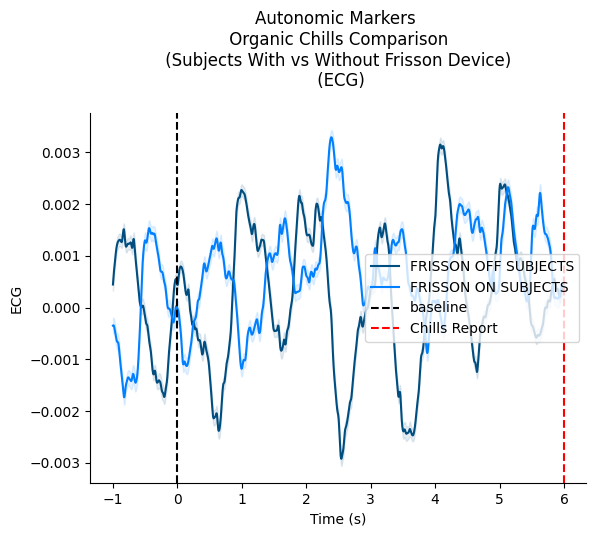

In [ ]:
ch = select_channel["ecg"]

y = even_chills[bidx[0]:, ch].T
y_std = even_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON OFF SUBJECTS", color=(0, 0.3, 0.5, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.3, 0.5, 0.1))

y = odd_chills[bidx[0]:, ch].T
y_std = odd_chills_std[:, ch]
plt.plot(np.arange(-1, 6, 1/fs), y, label="FRISSON ON SUBJECTS", color=(0, 0.5, 1, 1))
plt.fill_between(np.arange(-1, 6, 1/fs), y - y_std, y + y_std, color=(0, 0.5, 1, 0.1))

plt.axvline(0, color="black", linestyle="--", label="baseline")
plt.axvline(6, color="red", linestyle="--", label="Chills Report")

plt.gca().spines["top"].set_visible(False)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.ylabel("ECG")
plt.xlabel("Time (s)")

plt.legend(loc="center right")
plt.grid(False)

plt.title("Autonomic Markers \n Organic Chills Comparison \n (Subjects With vs Without Frisson Device) \n (ECG)", y=1.05)
plt.savefig("plots/ecg_organic_chills_comparison.png", dpi=300, bbox_inches="tight")

#### Frequency Domain

In [ ]:
N = int(fs*TIME_WINDOW)
T = 1/fs

even_chills_epochs_fft = np.abs(fft(even_chills_epochs[:, bidx[1]:, :], axis=1)[:, N//2:, :])**2
odd_chills_epochs_fft = np.abs(fft(odd_chills_epochs[:, bidx[1]:, :], axis=1)[:, N//2:, :])**2

even_chills_fft = even_chills_epochs_fft.mean(axis=0)
odd_chills_fft = odd_chills_epochs_fft.mean(axis=0)

freqs = fftfreq(N, T)[:N//2]
freqs_idx = (freqs < 4)
freqs = freqs[freqs_idx]

even_chills_fft = even_chills_fft[freqs_idx, :]
odd_chills_fft = odd_chills_fft[freqs_idx, :]

In [ ]:
even_chills_fft_std = even_chills_epochs_fft.std(axis=0) / len(even_chills_epochs_fft)
odd_chills_fft_std = odd_chills_epochs_fft.std(axis=0) / len(odd_chills_epochs_fft)

even_chills_fft_std = even_chills_fft_std[freqs_idx, :]
odd_chills_fft_std = odd_chills_fft_std[freqs_idx, :]

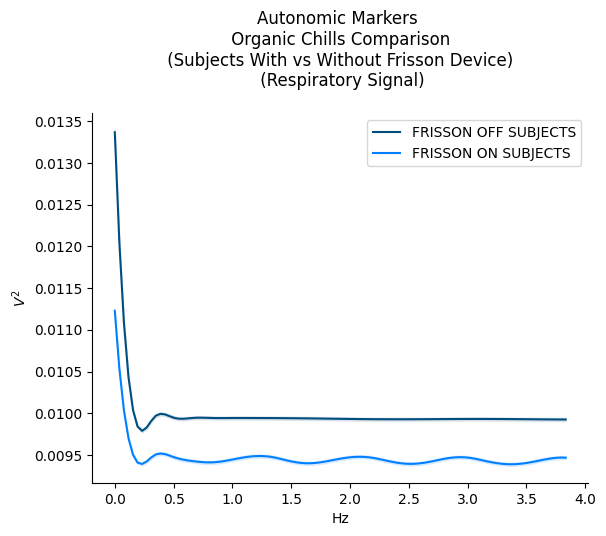

In [ ]:
ch = select_channel["resp"]

new_freqs = np.linspace(freqs.min(), freqs.max(), 100)
even_chills_fft_ = CubicSpline(freqs, even_chills_fft[:, ch])(new_freqs)
odd_chills_fft_ = CubicSpline(freqs, odd_chills_fft[:, ch])(new_freqs)

y = even_chills_fft_
y_std = CubicSpline(freqs, even_chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(0, 0.3, 0.5, 1), label="FRISSON OFF SUBJECTS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0.3, 0.5, 0.1))

y = odd_chills_fft_
y_std = CubicSpline(freqs, odd_chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(0, 0.5, 1, 1), label="FRISSON ON SUBJECTS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0.5, 1, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.legend(loc="upper right")
plt.ylabel(r"$V^2$")
plt.xlabel("Hz")

plt.title("Autonomic Markers \n Organic Chills Comparison \n (Subjects With vs Without Frisson Device) \n (Respiratory Signal)", y=1.05)
plt.savefig("plots/resp_organic_chills_fft_comparison.png", dpi=300, bbox_inches="tight")

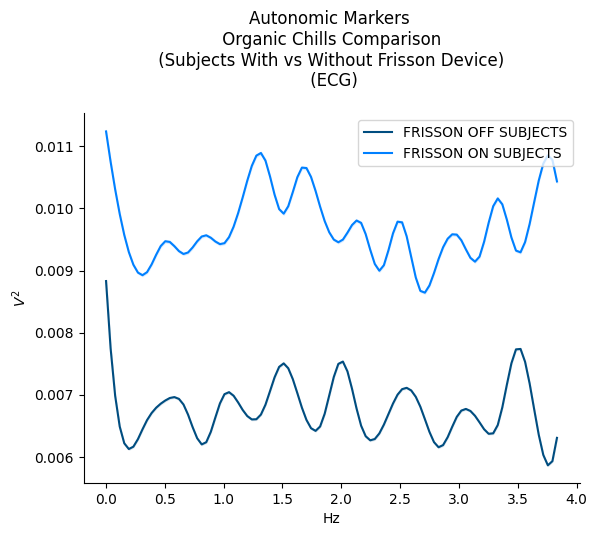

In [ ]:
ch = select_channel["ecg"]

new_freqs = np.linspace(freqs.min(), freqs.max(), 100)
even_chills_fft_ = CubicSpline(freqs, even_chills_fft[:, ch])(new_freqs)
odd_chills_fft_ = CubicSpline(freqs, odd_chills_fft[:, ch])(new_freqs)

y = even_chills_fft_
y_std = CubicSpline(freqs, even_chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(0, 0.3, 0.5, 1), label="FRISSON OFF SUBJECTS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0.3, 0.5, 0.1))

y = odd_chills_fft_
y_std = CubicSpline(freqs, odd_chills_fft_std[:, ch])(new_freqs)
plt.plot(new_freqs, y, color=(0, 0.5, 1, 1), label="FRISSON ON SUBJECTS")
plt.fill_between(new_freqs, y - y_std, y + y_std, color=(0, 0.5, 1, 0.1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.legend(loc="upper right")
plt.ylabel(r"$V^2$")
plt.xlabel("Hz")

plt.title("Autonomic Markers \n Organic Chills Comparison \n (Subjects With vs Without Frisson Device) \n (ECG)", y=1.05)
plt.savefig("plots/ecg_organic_chills_fft_comparison.png", dpi=300, bbox_inches="tight")

# Download Artifacts

In [ ]:
shutil.make_archive("plots", 'zip', "plots")
files.download("plots.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>